# Downsampling - mean pixel method

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import load_neo, write_neo, none_or_str, save_plot, \
                  AnalogSignal2ImageSequence, ImageSequence2AnalogSignal
import neo
import quantities as pq

## Loading .nix file

In [2]:
# load the neo block (output of the stage_01)
block = load_neo('LENS_170110_mouse2_t1.nix')

# Converting into images

In [3]:
# trasformation in the "ImageSequence" class
blockIm = AnalogSignal2ImageSequence(block)
# converts the imagesequence class in a 3D Numpy array
imgseq = blockIm.segments[0].imagesequences[-1]
imgseq_array = imgseq.as_array()

In [4]:
blockIm.segments[0].imagesequences[0].spatial_scale

array(0.05) * mm

## Downsampling script - simple mean on pixels

In [5]:
# Downsampling of nxn pixels, through a simple mean of internal pixels
d = 0.12 # mm
new_res = np.array(d) * pq.mm # macropixel side
orig_res = block.segments[0].analogsignals[0].annotations["spatial_scale"] # original pixel side

#check if the resolution is correct
if new_res.magnitude.tolist() < orig_res.magnitude.tolist(): 
    print("ERROR - New spatial scale must be greater than the original one. \n")

n = round((new_res/orig_res).magnitude.tolist()) # number of pixels in a side of the macropixel
orig_side = np.shape(imgseq_array[0])[0] # original grid side = 100 (pixels)
new_dim = n**(np.ndim(imgseq_array[0])) # n^(grid dimensions=2)
new_side = int(orig_side/n) # new grid side (pixels), takes the least nearest integer
#ToDo: think about alternatives to the least nearest integer
tmax = np.shape(imgseq_array)[0] # total frames = 1000
down = np.zeros((tmax, new_side, new_side)) # new 3D numpy matrix with downsampled data
for t in range(tmax):
    for i in range(new_side):
        for j in range(new_side):
            z = 0
            for k in range(n):
                for l in range(n):
                    z += imgseq_array[t][n*i + k][n*j + l]
            down[t][i][j] = z/new_dim

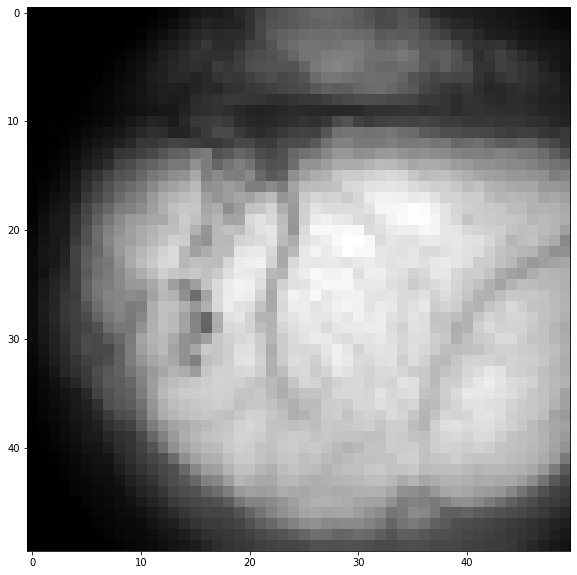

In [6]:
# 50x50 picture of the [0] frame with downsampling
plt.figure(figsize=(10,10))
plt.imshow(down[0], interpolation='nearest', cmap=plt.cm.gray)
#plt.savefig(fname='downsampled0.png')

Comparison with the original image

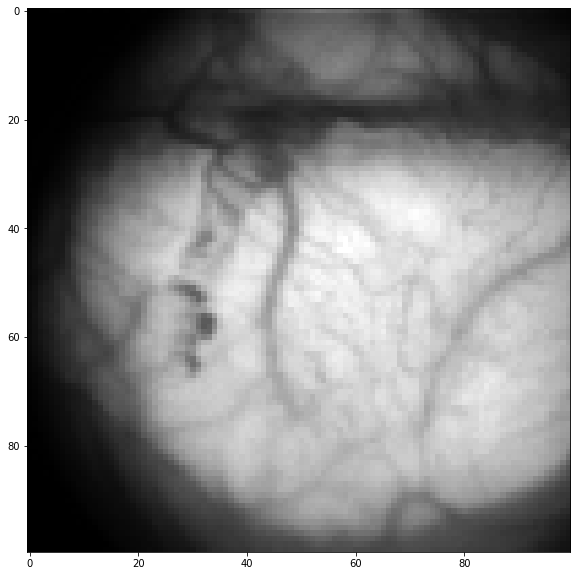

In [7]:
# original 100x100 picture of the same [0] frame
plt.figure(figsize=(10,10))
plt.imshow(imgseq_array[0], interpolation='nearest', cmap=plt.cm.gray)
#plt.savefig(fname='original0.png')

## Downsampling - no mean on pixels

In [8]:
d = 0.10 # mm
new_res = d * pq.mm # macropixel side
orig_res = block.segments[0].analogsignals[0].annotations["spatial_scale"]

#controllo sulle dimensioni
if new_res.magnitude.tolist() < orig_res.magnitude.tolist(): 
    print("ERROR - New spatial scale must be greater than the original one. \n")

n = round((new_res/orig_res).magnitude.tolist()) # number of pixels in a side of the macropixel
orig_side = np.shape(imgseq_array[0])[0] # original grid side = 100 (pixels)
new_dim = n**(np.ndim(imgseq_array[0])) # n^(grid dimensions=2)
new_side = int(orig_side/n) # new grid side (pixels), takes the least nearest integer
#ToDo: think about alternatives to the least nearest integer
tmax = np.shape(imgseq_array)[0] # total frames = 1000
down = np.zeros((tmax, new_side, new_side)) # new 3D numpy matrix with downsampled data

if n%2==0: # even number of pixels in one side
    for t in range(tmax):
        for i in range(new_side):
            for j in range(new_side):
                down[t][i][j] = imgseq_array[t][i*n+int(n/2)][j*n+int(n/2)] # takes the quasi-central pixel in the macropixel

else: # odd number of pixels in one side
    for t in range(tmax):
        for i in range(new_side):
            for j in range(new_side):
                down[t][i][j] = imgseq_array[t][i*n+int(n/2)+1][j*n+int(n/2)+1] #takes the central pixel in the macropixel

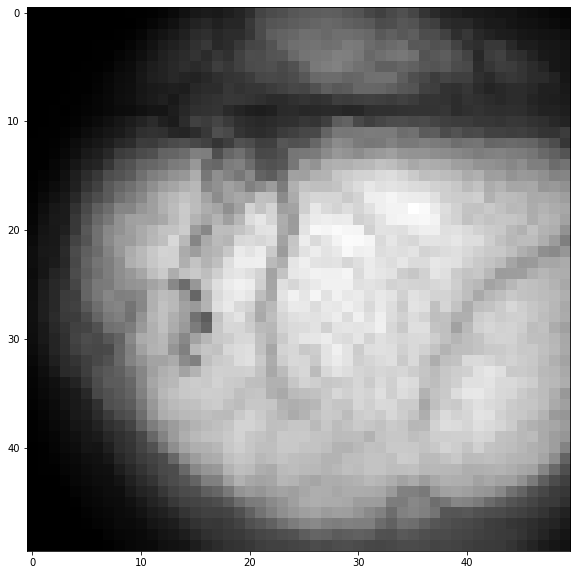

In [9]:
# 50x50 picture of the [0] frame with downsampling
plt.figure(figsize=(10,10))
plt.imshow(down[0], interpolation='nearest', cmap=plt.cm.gray)
#plt.savefig(fname='downsampled0.png')

# Writing of the .nix file with the downsapled block

In [10]:
# create an ImageSequence with the downsampled matrix
I = neo.ImageSequence(imgseq_array, units = block.segments[0].analogsignals[0].units, 
                      sampling_rate = block.segments[0].analogsignals[0].sampling_rate, 
                      spatial_scale = orig_res*n, name = block.segments[0].analogsignals[0].name, 
                      description = block.segments[0].analogsignals[0].description)

In [11]:
# create a new Block, Segment and append the ImageSequence
S = neo.Segment()
S.imagesequences.append(I)
B = neo.Block()
B.segments.append(S)
B.name = block.name
B.description = block.description
B.annotations = block.annotations

In [12]:
# converting into analogsignal 
out_block = ImageSequence2AnalogSignal(B)

In [13]:
# writing of the new file with downsampling
#write_neo('downsampled.nix', out_block)